# Significant Collocations

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures, TrigramAssocMeasures, QuadgramAssocMeasures

tqdm.pandas()
set_config(display="diagram")

In [2]:
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', delimiter=',', encoding='latin-1', header=None).fillna('')
df = df.rename(columns=lambda x: ['sentiment', 'text'][x])
print(df.shape)
df.head()

(4846, 2)


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
class SignificantCollocations(BaseEstimator, TransformerMixin):
    def __init__(self, ngram):
        self.ngram=ngram
        if ngram == 2:
            self.ngram_class = BigramCollocationFinder
            self.metric = BigramAssocMeasures
        elif ngram == 3:
            self.ngram_class = TrigramCollocationFinder
            self.metric = TrigramAssocMeasures
        elif ngram == 4:
            self.ngram_class = QuadgramCollocationFinder
            self.metric = QuadgramAssocMeasures
        else:
            raise ValueError("invalid ngram value")
    
    def fit(self, X, y=None):
        ngrams = self.ngram_class.from_documents(X)
        self.scored_ = dict(ngrams.score_ngrams(self.metric.pmi))
        return self
    
    def transform(self, X, y=None):
        for x in X:
            ngrams = self.ngram_class.from_words(x.split())
            yield {
                ngram: self.scored_.get(ngram, 0.0) for ngram in ngrams.nbest(self.metric.raw_freq, 3)
            }
    

In [4]:
get_model = lambda: Pipeline([
    ('vectorizer', FeatureUnion([
        ('uni', TfidfVectorizer(sublinear_tf=True)),
        ('bi', Pipeline([('extractor', SignificantCollocations(2)), ('vectorizer', DictVectorizer())])),
        ('tri', Pipeline([('extractor', SignificantCollocations(3)), ('vectorizer', DictVectorizer())])),
        ('quad', Pipeline([('extractor', SignificantCollocations(4)), ('vectorizer', DictVectorizer())])),
    ])),
    ('estimator', LogisticRegression(max_iter=100_000, random_state=19, class_weight="balanced"))
])
get_model()

Pipeline(steps=[('vectorizer',
                 FeatureUnion(transformer_list=[('uni',
                                                 TfidfVectorizer(sublinear_tf=True)),
                                                ('bi',
                                                 Pipeline(steps=[('extractor',
                                                                  SignificantCollocations(ngram=2)),
                                                                 ('vectorizer',
                                                                  DictVectorizer())])),
                                                ('tri',
                                                 Pipeline(steps=[('extractor',
                                                                  SignificantCollocations(ngram=3)),
                                                                 ('vectorizer',
                                                                  DictVectorizer())])),
                                                ('quad',
                                                 Pipeline(steps=[('extractor',
                                                                  SignificantCollocations(ngram=4)),
                                                                 ('vectorizer',
                                                                  DictVectorizer())]))])),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=100000,
                                    random_state=19))])

In [5]:
x = df['text']
y = df['sentiment']

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)
scores = []
models = []
for train_index, valid_index in tqdm(skf.split(x, y), total=10):
    x_train, x_valid = x.iloc[train_index], x.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    model = get_model().fit(x_train, y_train)
    models.append(model)
    scores.append(model.score(x_valid, y_valid))
print(np.mean(scores))

  0%|          | 0/10 [00:00<?, ?it/s]

0.757943682371986


In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def plot_feature_importance(model, ax, fold):
    coefs = minmax_scale(model.named_steps['estimator'].coef_.mean(axis=0), feature_range=(-1,1))
    n_features = [
        len(model.named_steps['vectorizer'].transformer_list[0][1].get_feature_names_out()),
        len(model.named_steps['vectorizer'].transformer_list[1][1].named_steps['vectorizer'].get_feature_names_out()),
        len(model.named_steps['vectorizer'].transformer_list[2][1].named_steps['vectorizer'].get_feature_names_out()),
        len(model.named_steps['vectorizer'].transformer_list[3][1].named_steps['vectorizer'].get_feature_names_out()),
    ]
    v_lines = np.cumsum(n_features)[:-1]
    ax.plot(coefs)
    for x in v_lines:
        ax.axvline(x=x, color = 'r')
    ax.set_title(f"Feature Importance fold {fold+1}")

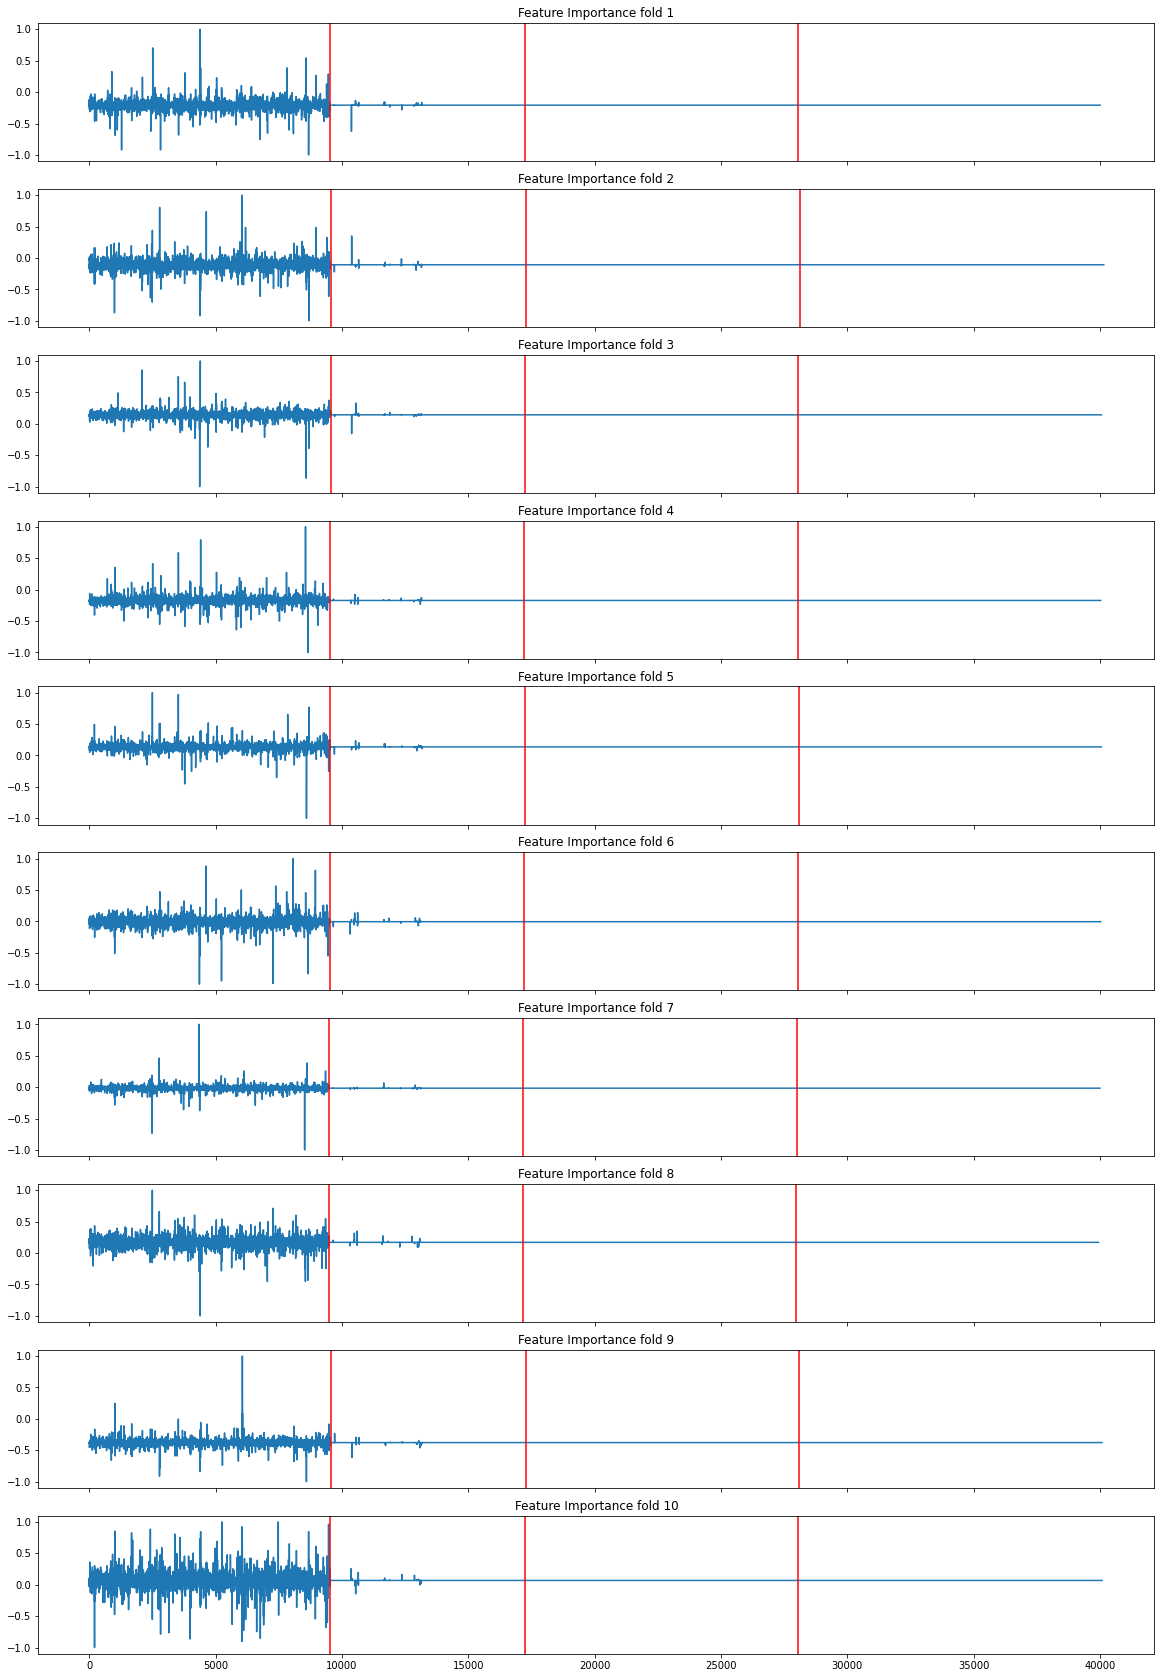

In [7]:
fig, ax = plt.subplots(10, 1, figsize=(20, 30), sharex=True)
for i in range(10):
    plot_feature_importance(models[i], ax[i], i)